***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Vorlesung 8: Subordination, Koordination, Verbalkomplex

In [1]:
import nltk

In [2]:
import spacy
from spacy import displacy

In [3]:
def transform_nr_conll(sent_nr):
    sent_list = []
    for line in list(filter(None, sent_nr.split("\n"))):
        line_list = line.split()
        line_list.pop(0)
        line_list.insert(1,"_")
        sent_list.append(" ".join([i for i in line_list[0:]]))

    return "\n".join([i for i in sent_list[0:]])

In [4]:
from nltk import DependencyGraph
from nltk.tree import Tree
from itertools import chain


### tree_labeled-Methode für DependencyGraphs (pretty_print-Dependenzbäume mit Labels):
def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

    
DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled

In [5]:
#Konvertierungsfunktion von conll(4)-Format (MALT-tabular) für Rendering mit displaCy:
def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex

#html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

In [6]:
def show_dep_trees(sent_nr):
    sent = transform_nr_conll(sent_nr)
    dg = DependencyGraph(sent)

    tree_labeled = dg.tree_labeled()
    tree_labeled.pretty_print(unicodelines=True)   
    
    ex = displacy_dep_input(sent)
    html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

In [7]:
def show_const_tree(grammar, sentence):
    parser = nltk.ChartParser(grammar,trace=0)
    sent = sentence.split()
    for tree in parser.parse(sent):
#        tree.pretty_print(unicodelines=True)
        display(tree)

## Label:
- TIGER-DEPENDENCY-LABEL: https://www.linguistik.hu-berlin.de/de/institut/professuren/korpuslinguistik/mitarbeiter-innen/hagen/DDB_edge
- UD-LABEL: https://universaldependencies.org/u/dep/


- PENN-TREEBANK: http://www.surdeanu.info/mihai/teaching/ista555-fall13/readings/PennTreebankConstituents.html#Clause


--- 

---

# 1. Komplementsätze

## 1.1 Objektsatz

In [8]:
sentence = "ich glaube dass du lügst"

### *Konstituentenanalyse:*

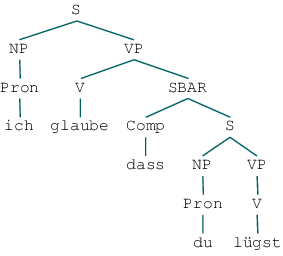

In [9]:
grammar = nltk.CFG.fromstring("""
 S -> NP VP
 NP -> Pron
 VP -> V
 
 VP -> V SBAR
 SBAR -> Comp S

 Pron -> 'ich' | 'du'
 Comp -> 'dass'
 V -> 'glaube' | 'lüge' | 'glaubst' | 'lügst'
""")

show_const_tree(grammar, sentence)

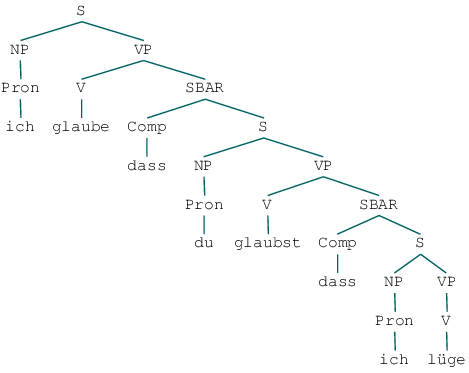

In [10]:
#rekursive Einbettung:
sentence = "ich glaube dass du glaubst dass ich lüge"

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [11]:
sent_nr = """
1 ich 2 nsubj  
2 glaube 0 ROOT
3 dass 5 mark
4 du 5 nsubj
5 lügst 2 ccomp
"""

show_dep_trees(sent_nr)

           glaube(ROOT)                       
    ┌───────────┴────────────┐                 
    │                   lügst(ccomp)          
    │           ┌────────────┴───────────┐     
ich(nsubj)  dass(mark)               du(nsubj)



In [12]:
print(spacy.explain('ccomp'), spacy.explain('mark'), sep="\n")

clausal complement
marker


---
### *Dependenzanalyse TIGER:*

In [13]:
sent_nr = """
1 ich 2 sb  
2 glaube 0 ROOT
3 dass 5 cp
4 du 5 sb
5 lügst 2 oc
"""

show_dep_trees(sent_nr)

        glaube(ROOT)                 
   ┌─────────┴───────────┐            
   │                 lügst(oc)       
   │         ┌───────────┴───────┐    
ich(sb)   dass(cp)             du(sb)



In [14]:
print(spacy.explain('oc'), spacy.explain('cp'), sep="\n")

clausal object
complementizer


---
## 1.2 Subjektsatz

In [15]:
sentence = "dass jemand geht ist falsch"

### *Konstituentenanalyse:*

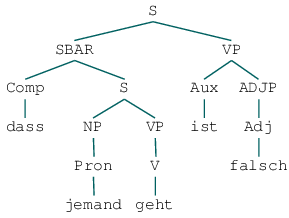

In [16]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pron
VP -> V

S -> SBAR VP
SBAR -> Comp S

VP -> Aux ADJP
ADJP -> Adj

Comp -> 'dass'
V -> 'geht'
Aux -> 'ist'
Adj -> 'falsch'
Pron -> 'jemand'
""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [17]:
sent_nr = """
1 dass 3 mark
2 jemand 3 nsubj 
3 geht 5 csubj
4 ist 5 cop
5 falsch 0 ROOT
"""

show_dep_trees(sent_nr)

         falsch(ROOT)                          
   ┌──────────┴────────────┐                    
   │                  geht(csubj)              
   │          ┌────────────┴────────────┐       
ist(cop)  dass(mark)              jemand(nsubj)



In [18]:
print(spacy.explain('csubj'), spacy.explain('nsubj'), spacy.explain('mark'), spacy.explain('aux'), sep="\n")

clausal subject
nominal subject
marker
auxiliary


---
### *Dependenzanalyse TIGER:*

In [19]:
sent_nr = """
1 dass 3 cp
2 jemand 3 sb 
3 geht 4 sb
4 ist 0 ROOT
5 falsch 4 pd
"""

show_dep_trees(sent_nr)

           ist(ROOT)                    
    ┌──────────┴────────┐                
    │                geht(sb)           
    │          ┌────────┴─────────┐      
falsch(pd)  dass(cp)          jemand(sb)



In [20]:
print(spacy.explain('sb'), spacy.explain('cp'), spacy.explain('pd'), sep="\n")

subject
complementizer
predicate


---
# 2. Adverbialer Nebensatz

In [21]:
sentence = "als der Sturm begann fror sie"

### *Konstituentenanalyse:*

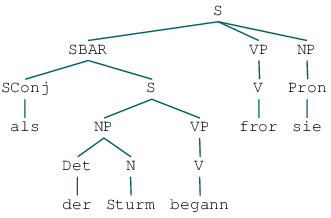

In [22]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det N
VP -> V
NP -> Pron

S -> SBAR VP NP
SBAR -> SConj S

SConj -> 'als'
Det -> 'der'
N -> 'Sturm'
Pron -> 'sie'
V -> 'fror' | 'begann'
""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [23]:
sent_nr = """
1 als 4 mark
2 der 3 det
3 Sturm 4 nsubj
4 begann 5 advcl
5 fror 0 ROOT
6 sie 5 nsubj
"""

show_dep_trees(sent_nr)

           fror(ROOT)                           
    ┌──────────┴────────────┐                    
    │                 begann(advcl)             
    │          ┌────────────┴────────────┐       
    │          │                    Sturm(nsubj)
    │          │                         │       
sie(nsubj) als(mark)                  der(det)  



In [24]:
print(spacy.explain('advcl'), spacy.explain('mark'), sep="\n")

adverbial clause modifier
marker


---
### *Dependenzanalyse TIGER:*

In [25]:
sent_nr = """
1 als 4 cp
2 der 3 nk
3 Sturm 4 sb
4 begann 5 mo
5 fror 0 ROOT
6 sie 5 sb
"""

show_dep_trees(sent_nr)

        fror(ROOT)                     
   ┌────────┴──────────┐                
   │               begann(mo)          
   │        ┌──────────┴──────────┐     
   │        │                 Sturm(sb)
   │        │                     │     
sie(sb)  als(cp)               der(nk) 



In [26]:
print(spacy.explain('mo'), spacy.explain('cp'), sep="\n")

modifier
complementizer


---
# 3. Attributsätze: Relativsatz

In [27]:
sentence = "der Mann der zu viel wusste"

### *Konstituentenanalyse:*

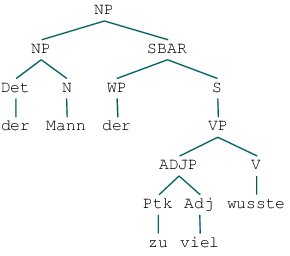

In [28]:
grammar = nltk.CFG.fromstring("""
NP -> NP SBAR
NP -> Det N
SBAR -> WP S

S -> VP
VP -> ADJP V

ADJP -> Ptk Adj

S -> NP VP

Det -> 'der'
N -> 'Mann'
WP -> 'der'
V -> 'wusste'
Ptk -> 'zu'
Adj -> 'viel'

""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [29]:
sent_nr = """
1 der 2 det
2 Mann 0 ROOT
3 der 6 nsubj
4 zu 5 advmod
5 viel 6 advmod
6 wusste 2 acl:relcl
"""

show_dep_trees(sent_nr)

         Mann(ROOT)                               
   ┌─────────┴──────────────┐                      
   │                wusste(acl:relcl)             
   │         ┌──────────────┴──────────────┐       
   │         │                        viel(advmod)
   │         │                             │       
der(det) der(nsubj)                    zu(advmod) 



In [30]:
print(spacy.explain('acl'), spacy.explain('relcl'), sep="\n")

clausal modifier of noun (adjectival clause)
relative clause modifier


---
### *Dependenzanalyse TIGER:*

In [31]:
sent_nr = """
1 der 2 nk
2 Mann 0 ROOT
3 der 6 sb
4 zu 5 mo
5 viel 6 mo
6 wusste 2 rc
"""

show_dep_trees(sent_nr)

        Mann(ROOT)                    
   ┌────────┴──────────┐               
   │               wusste(rc)         
   │        ┌──────────┴─────────┐     
   │        │                 viel(mo)
   │        │                    │     
der(nk)  der(sb)               zu(mo) 



In [32]:
print(spacy.explain('rc'), sep="\n")

relative clause


---
# 4. Infinitiv-Konstruktionen

---
## 4.1 Auxiliar + Kopula (komplexe VP / Verbalkomplex)

In [33]:
sentence = "das kann nicht richtig sein"

### *Konstituentenanalyse:*

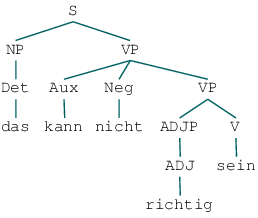

In [34]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det
VP -> Aux Neg VP
VP -> ADJP V
ADJP -> ADJ

Det -> 'das'
Aux -> 'kann'
Neg -> 'nicht'
V -> 'sein'
ADJ -> 'richtig'
""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [35]:
sent_nr = """
1 das 4 nsubj
2 kann 4 aux
3 nicht 4 neg
4 richtig 0 ROOT
5 sein 4 cop
"""

show_dep_trees(sent_nr)

           richtig(ROOT)                     
    ┌────────────┼───────────┬──────────┐     
das(nsubj)   kann(aux)   nicht(neg) sein(cop)



In [36]:
print(spacy.explain('aux'), spacy.explain('cop'), spacy.explain('neg'), sep="\n")

auxiliary
copula
negation modifier


---
### *Dependenzanalyse TIGER:*

In [37]:
sent_nr = """
1 das 2 sb
2 kann 0 ROOT
3 nicht 2 ng
4 richtig 5 pd 
5 sein 2 oc
"""

show_dep_trees(sent_nr)

        kann(ROOT)            
   ┌────────┼───────────┐      
   │        │        sein(oc) 
   │        │           │      
das(sb) nicht(ng)  richtig(pd)



In [38]:
print(spacy.explain('oc'), spacy.explain('pd'), spacy.explain('ng'), sep="\n")

clausal object
predicate
negation


---
##  4.2 Infinitiv-Objektsatz

- *überzeugen*: Objektkontrolle (Objekt des Hauptsatzes ist semantisches Subjekt des Infinitivsatzes)
- (dagegen z.B. *versprechen*: Subjektkontrolle)

In [39]:
sentence = "sie überzeugen ihn zu fahren"

### *Konstituentenanalyse:*

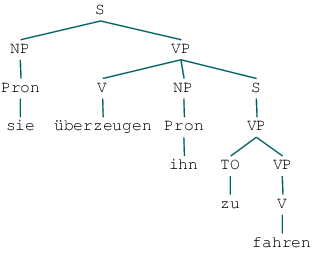

In [40]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pron
VP -> V

VP -> V NP S
##subjektloser Satz (Infinitiv-Satz):
S -> VP
VP -> TO VP


TO -> 'zu'
Pron -> 'sie' | 'ihn'
V -> 'überzeugen' | 'fahren'
""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [41]:
sent_nr = """
1 sie 2 nsubj  
2 überzeugen 0 ROOT
3 ihn 2 obj
4 zu 5 mark
5 fahren 2 xcomp
"""

show_dep_trees(sent_nr)

           überzeugen(ROOT)              
    ┌─────────────┼───────────────┐       
    │             │         fahren(xcomp)
    │             │               │       
sie(nsubj)     ihn(obj)        zu(mark)  



In [42]:
print(spacy.explain('xcomp'), spacy.explain('mark'), sep="\n")

open clausal complement
marker


---
### *Dependenzanalyse TIGER:*

In [43]:
sent_nr = """
1 sie 2 sb  
2 überzeugen 0 ROOT
3 ihn 2 oa
4 zu 5 pm
5 fahren 2 oc
"""

show_dep_trees(sent_nr)

        überzeugen(ROOT)           
   ┌───────────┼─────────────┐      
   │           │         fahren(oc)
   │           │             │      
sie(sb)     ihn(oa)        zu(pm)  



In [44]:
print(spacy.explain('oc'), spacy.explain('pm'), sep="\n")

clausal object
morphological particle


---
## 4.3 Infinitiv-Subjektsatz

In [45]:
sentence = "zu gehen wäre falsch"

### *Konstituentenanalyse:*

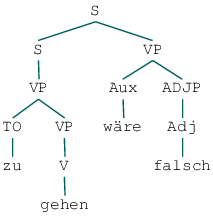

In [46]:
grammar = nltk.CFG.fromstring("""
S -> S VP

S -> VP
VP -> TO VP
VP -> Aux VP

VP -> V
VP -> Aux ADJP
ADJP -> Adj

TO -> 'zu'
V -> 'gehen'
Aux -> 'wäre'
Adj -> 'falsch'
""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [47]:
sent_nr = """
1 zu 2 mark
2 gehen 4 csubj
3 wäre 4 cop
4 falsch 0 ROOT
"""

show_dep_trees(sent_nr)

          falsch(ROOT)             
    ┌──────────┴────────────┐       
    │                  gehen(csubj)
    │                       │       
wäre(cop)                zu(mark)  



In [48]:
print(spacy.explain('csubj'), spacy.explain('mark'), spacy.explain('aux'), sep="\n")

clausal subject
marker
auxiliary


---
### *Dependenzanalyse TIGER:*

In [49]:
sent_nr = """
1 zu 2 pm
2 gehen 3 sb
3 wäre 0 ROOT
4 falsch 3 pd
"""

show_dep_trees(sent_nr)

           wäre(ROOT)          
    ┌──────────┴──────────┐     
    │                 gehen(sb)
    │                     │     
falsch(pd)              zu(pm) 



In [50]:
print(spacy.explain('sb'), spacy.explain('pm'), spacy.explain('pd'), sep="\n")

subject
morphological particle
predicate


---
## 5. Koordination

In [51]:
sentence = "sie kamen und sie sahen"

### *Konstituentenanalyse:*

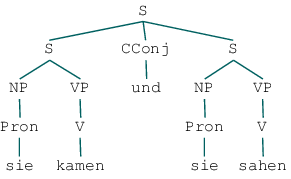

In [52]:
grammar = nltk.CFG.fromstring("""
S -> S CConj S
S -> NP VP
NP -> Pron
VP -> V

Pron -> 'sie'
V -> 'kamen' | 'sahen'
CConj -> 'und'
""")

show_const_tree(grammar, sentence)

---
### *Dependenzanalyse UD:*

In [53]:
sent_nr = """
1 sie 2 nsubj
2 kamen 0 ROOT
3 und 5 cc
4 sie 5 nsubj
5 sahen 2 conj
"""

show_dep_trees(sent_nr)

           kamen(ROOT)                       
    ┌───────────┴───────────┐                 
    │                  sahen(conj)           
    │           ┌───────────┴──────────┐      
sie(nsubj)   und(cc)               sie(nsubj)



In [54]:
print(spacy.explain('cc'), spacy.explain('conj'), sep="\n")

coordinating conjunction
conjunct


---
### *Dependenzanalyse TIGER:*

In [55]:
sent_nr = """
1 sie 2 sb
2 kamen 0 ROOT
3 und 2 cd
4 sie 5 sb
5 sahen 3 cj
"""

show_dep_trees(sent_nr)

        kamen(ROOT)          
   ┌─────────┴──────────┐     
   │                 und(cd) 
   │                    │     
   │                sahen(cj)
   │                    │     
sie(sb)              sie(sb) 



In [56]:
print(spacy.explain('cd'), spacy.explain('cj'), sep="\n")

coordinating conjunction
conjunct
